In [1]:
%pylab inline
from scipy.integrate import solve_ivp
from IPython import display
import time
import scipy.integrate as integrate

Populating the interactive namespace from numpy and matplotlib


### Initializations

In [2]:
# the 1D space
length = 30.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)


# the diffusion coefficients
D_n = 11
Ds = logspace(-2,3,D_n,base = 10)

# the initial substrate concentrations
atot_n = 11
atots = logspace(0,5,D_n,base = 10)

# will be used to determine atot (atot = N) when only D is specified  
# and used to determine D (D = atot/N) when only atot is specified
N = 100.0 

nu = 1.0 # raw burn rate

dt = 0.001
tf = 400.0 #each run goes for (tf/dt) steps 
run_n = 50 # number of runs

### Unbiased initial substrate 
#### efficiency vs. D (a0 = 1/sigma)

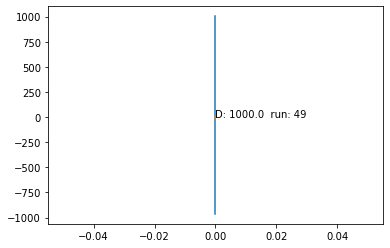

In [4]:

sol_0D = []
for D in Ds: 
    sol_1 = []
    tf = 400.0 #run for (tf/dt) steps 
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx) #initialize bound complex
        
        #intialize substrate
        As = zeros(Nx) 
        As[xs > 2.0] = N # here atot = N
        As[xs < -2.0] = N

        # some values to save for each time step
        xp_t = [] # position
        v_t = [] # times
        burn_t = [] # burn rate
        
        noisescale = sqrt(2*dt*D) # the scale of diffusion
        t_max = int(tf/dt)
        for t in range(t_max): 
            
            total_f = D * trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt
            noise = noisescale* random.normal(0.0,1.0)
            
            xp += total_f * dt + noise # update position

            if t % 10.0 == 0.0: # save values
                xp_t.append(xp)
                v_t.append(total_f+noise/dt)
                burn_t.append(trapz(Ac*nu,x=xs))
                
            if t % 1000.0 == 0.0 and run ==0: # see what's going on
                display.clear_output(wait=True)
                cla()
                plot(xs,Ac)
                plot(xs,As)
                axvline(xp)
                text(-length,N,"D: "+str(round(D,3)))
                display.display(gcf())
    
            if abs(xp) > length -5.0: # stop before it hits an edge
                break
                
        # see the velocity and position for the run        
        display.clear_output(wait=True)
        cla()
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),v_t)
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),xp_t)
        text(0.0,0.0,"D: "+str(round(D,3))+"  run: " +str(run))
        display.display(gcf())
        
        # save the mean velocity and burn rate for the last 90% of the run
        sol_1.append([abs(mean(v_t[-int(t*0.9):])),mean(burn_t[-int(t*0.9):])])
    # save these for each diffusion coefficient
    sol_0D.append(sol_1)
display.clear_output(wait=True)

### Unbiased initial substrate 
#### efficiency vs. D (a0 = gamma r siglam / KB T)

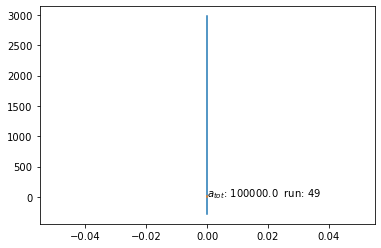

In [5]:

sol_0atot = [] 
for atot in atots: 
    sol_1 = []
    tf = 400.0 #run for (tf/dt) steps 
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx) #initialize bound complex
        
        #initialize substrate
        As = zeros(Nx) 
        As[xs > 2.0] = atot
        As[xs < -2.0] = atot

        
        # some values to save for each time step
        xp_t = [] # position
        v_t = [] # times
        burn_t = [] # burn rate
        
        noisescale = sqrt(2*dt*atot/N) # the scale of diffusion
        t_max = int(tf/dt)
        for t in range(t_max): 
            
            total_f = trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt
            noise = noisescale* random.normal(0.0,1.0)
            
            xp += total_f * dt + noise # update position

            if t % 10.0 == 0.0: # save values
                xp_t.append(xp)
                v_t.append(total_f+noise/dt)
                burn_t.append(trapz(Ac*nu,x=xs))
                
            if t % 1000.0 == 0.0 and run ==0: # see what's going on
                display.clear_output(wait=True)
                cla()
                plot(xs,Ac)
                plot(xs,As)
                axvline(xp)
                text(-length,atot,"$a_{tot}$: "+str(round(atot,3)))
                display.display(gcf())

            if abs(xp) > length -5.0: # stop before it hits an edge
                break
        
        # see the velocity and position for the run   
        display.clear_output(wait=True)
        cla()
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),v_t)
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),xp_t)
        text(0.0,0.0,"$a_{tot}$: "+str(round(atot,3))+"  run: " +str(run))
        display.display(gcf())
        
        # save the mean velocity and burn rate for the last 90% of the run
        sol_1.append([abs(mean(v_t[-int(t*0.9):])),mean(burn_t[-int(t*0.9):])])
    # save these for each diffusion coefficient
    sol_0atot.append(sol_1)
display.clear_output(wait=True)

### Biased initial substrate
#### efficiency vs. D (a0 = 1/sigma)

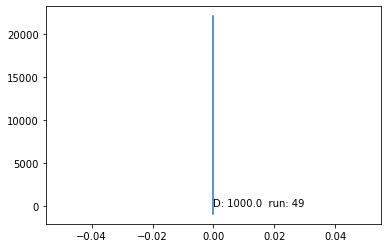

In [6]:

sol_0Db = []
for D in Ds: 
    sol_1 = []
    tf = 400.0 #run for (tf/dt) steps 
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx) #initialize bound complex
        
        #intialize substrate
        As = zeros(Nx) 
        As[xs > 0.0] = linspace(0.1,length,int(Lmax/dx)) * N/2.0 # create initial gradient with slope (a0/2.0)
        As[xs > 2.0] = N # biased to the right

        # some values to save for each time step
        xp_t = [] # position
        v_t = [] # times
        burn_t = [] # burn rate
        
        noisescale = sqrt(2*dt*D) # the scale of diffusion
        t_max = int(tf/dt)
        for t in range(t_max): 
            
            total_f = D * trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt
            noise = noisescale* random.normal(0.0,1.0)
            
            xp += total_f * dt + noise # update position

            if t % 10.0 == 0.0: # save values
                xp_t.append(xp)
                v_t.append(total_f+noise/dt)
                burn_t.append(trapz(Ac*nu,x=xs))
                
            if t % 1000.0 == 0.0 and run ==0: # see what's going on
                display.clear_output(wait=True)
                cla()
                plot(xs,Ac)
                plot(xs,As)
                axvline(xp)
                text(-length,N,"D: "+str(round(D,3)))
                display.display(gcf())
    
            if abs(xp) > length -5.0: # stop before it hits an edge
                break
                
        # see the velocity and position for the run        
        display.clear_output(wait=True)
        cla()
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),v_t)
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),xp_t)
        text(0.0,0.0,"D: "+str(round(D,3))+"  run: " +str(run))
        display.display(gcf())
        
        # save the mean velocity and burn rate for the last 90% of the run
        sol_1.append([abs(mean(v_t[-int(t*0.9):])),mean(burn_t[-int(t*0.9):])])
    # save these for each diffusion coefficient
    sol_0Db.append(sol_1)
display.clear_output(wait=True)

### Biased initial substrate 
#### efficiency vs. D (a0 = gamma r siglam / KB T)

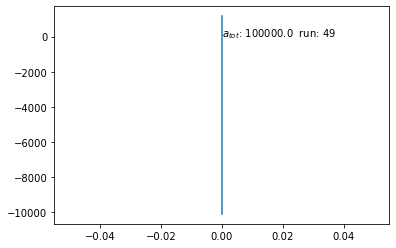

In [7]:

sol_0atotb = [] 
for atot in atots: 
    sol_1 = []
    tf = 400.0 #run for (tf/dt) steps 
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx) #initialize bound complex
        
        #initialize substrate
        As = zeros(Nx) 
        As[xs > 0.0] = linspace(0.1,length,int(Lmax/dx)) * atot/2.0 # create initial gradient with slope (a0/2.0)
        As[xs > 2.0] = atot # biased to the right

        
        # some values to save for each time step
        xp_t = [] # position
        v_t = [] # times
        burn_t = [] # burn rate
        
        noisescale = sqrt(2*dt*atot/N) # the scale of diffusion
        t_max = int(tf/dt)
        for t in range(t_max): 
            
            total_f = trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt
            noise = noisescale* random.normal(0.0,1.0)
            
            xp += total_f * dt + noise # update position

            if t % 10.0 == 0.0: # save values
                xp_t.append(xp)
                v_t.append(total_f+noise/dt)
                burn_t.append(trapz(Ac*nu,x=xs))
                
            if t % 1000.0 == 0.0 and run ==0: # see what's going on
                display.clear_output(wait=True)
                cla()
                plot(xs,Ac)
                plot(xs,As)
                axvline(xp)
                text(-length,atot,"$a_{tot}$: "+str(round(atot,3)))
                display.display(gcf())

            if abs(xp) > length -5.0: # stop before it hits an edge
                break
        
        # see the velocity and position for the run   
        display.clear_output(wait=True)
        cla()
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),v_t)
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),xp_t)
        text(0.0,0.0,"$a_{tot}$: "+str(round(atot,3))+"  run: " +str(run))
        display.display(gcf())
        
        # save the mean velocity and burn rate for the last 90% of the run
        sol_1.append([abs(mean(v_t[-int(t*0.9):])),mean(burn_t[-int(t*0.9):])])
    # save these for each diffusion coefficient
    sol_0atotb.append(sol_1)
display.clear_output(wait=True)

### plotting efficiency vs. D

Text(0, 0.5, 'Relative Efficiency')

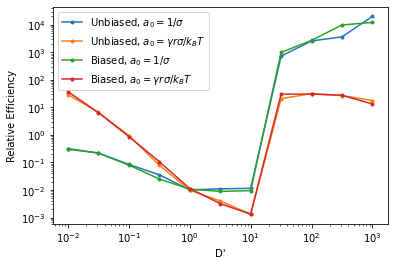

In [9]:
#plot all at once
sol_0D = array(sol_0D)
sol_0atot = array(sol_0atot)
sol_0Db = array(sol_0Db)
sol_0atotb = array(sol_0atotb)
effsD = []
for i in range(len(sol_0D)):
    vs = mean(sol_0D[i][:,0],axis=0)
    burns = mean(sol_0D[i][:,1],axis=0)
    effsD.append(N/atots[i] *vs**2 / burns)
effsatot = []
for i in range(len(sol_0atot)):
    vs = mean(sol_0atot[i][:,0],axis=0)
    burns = mean(sol_0atot[i][:,1],axis=0)
    effsatot.append(N/atots[i] *vs**2 / burns)
effsDb = []
for i in range(len(sol_0Db)):
    vs = mean(sol_0Db[i][:,0],axis=0)
    burns = mean(sol_0Db[i][:,1],axis=0)
    effsDb.append(N/atots[i] *vs**2 / burns)
effsatotb = []
for i in range(len(sol_0atotb)):
    vs = mean(sol_0atotb[i][:,0],axis=0)
    burns = mean(sol_0atotb[i][:,1],axis=0)
    effsatotb.append(N/atots[i] *vs**2 / burns)

plot(Ds,effsD,".-", label= "Unbiased, $a_0 = 1/\sigma$")
plot(atots/N,effsatot,".-",label= "Unbiased, $a_0 = \gamma r \sigma/ k_B T$")
plot(Ds,effsDb,".-", label= "Biased, $a_0 = 1/\sigma$")
plot(atots/N,effsatotb,".-", label= "Biased, $a_0 = \gamma r \sigma/ k_B T$")
legend()
xscale("log")
yscale('log')
xlabel("D'")
ylabel("Relative Efficiency")
    

### ensuring dt stable at dt = 1e-3
#### (a0 = 1/ sigma)

In [13]:

dt_n = 7
dts = logspace(-4,-1,dt_n,base = 10)
D = 1.0

sol_0 = []
for dt in dts: 
    sol_1 = []
    tf = 400.0
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx)
        
        As = zeros(Nx) 
        As[xs > 2.0] = N
        As[xs < -2.0] = N

        xp_t = []
        v_t = []
        burn_t = []
        
        noisescale = sqrt(2*dt*D)
        t_max = int(tf/dt)
        for t in range(t_max): 
            
            total_f = D * trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt
            noise = noisescale* random.normal(0.0,1.0)
            xp += total_f * dt + noise 

            if t % 10.0 == 0.0:
                xp_t.append(xp)
                v_t.append(total_f+noise/dt)
                burn_t.append(trapz(Ac*nu,x=xs))
                                
            if abs(xp) > length -5.0:
                break
        
        sol_1.append([abs(mean(v_t[-int(t*0.9):])),mean(burn_t[-int(t*0.9):])])
    sol_0.append(sol_1)

#### plot efficiency vs. dt (a0 = 1\sigma)

(7, 50, 2)


Text(0, 0.5, 'Relative Efficiency')

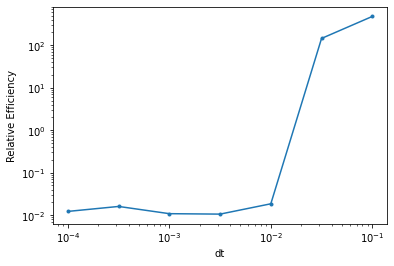

In [14]:
sol_0 = array(sol_0)
print(sol_0.shape)
effs = []
for i in range(len(sol_0)):
    vs = mean(sol_0[i][:,0],axis=0)
    burns = mean(sol_0[i][:,1],axis=0)
    effs.append(1/D *vs**2 / burns)
plot(dts,effs,".-")
#legend()
xscale("log")
yscale('log')
xlabel("dt")
ylabel("Relative Efficiency")
    

### ensuring dt stable at dt = 1e-3
#### (a0 = gamma r siglam / KB T)

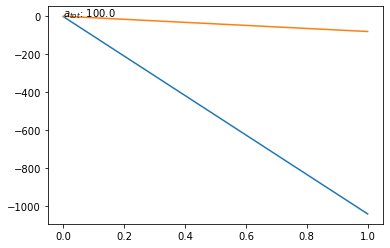

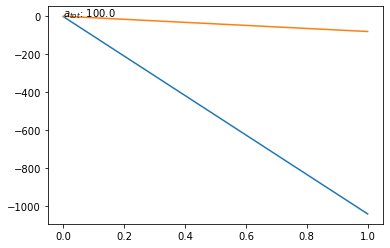

In [15]:

dt_n = 7
dts = logspace(-4,-1,dt_n,base = 10)
atot = 100.0

sol_0 = []
for dt in dts: 
    sol_1 = []
    tf = 400.0
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx)
        
        As = zeros(Nx) 
        As[xs > 2.0] = atot
        As[xs < -2.0] = atot

        t_max = int(tf/dt)
        xp_t = []
        v_t = []
        burn_t = []
        noisescale = sqrt(2*dt*atot/N)
        for t in range(t_max): 
            
            total_f = trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt
            noise = noisescale* random.normal(0.0,1.0)
            xp += total_f * dt + noise 

            if t % 10.0 == 0.0:
                xp_t.append(xp)
                v_t.append(total_f+noise/dt)
                burn_t.append(trapz(Ac*nu,x=xs))
                
            if t % 1000.0 == 0.0 and run ==0:
                display.clear_output(wait=True)
                cla()
                plot(xs,Ac)
                plot(xs,As)
                axvline(xp)
                text(-length,atot,"$a_{tot}$: "+str(round(atot,3)))
                display.display(gcf())
                
            if abs(xp) > length -5.0:
                break
                
        display.clear_output(wait=True)
        cla()
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),v_t)
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),xp_t)
        text(0.0,0.0,"$a_{tot}$: "+str(round(atot,3)))
        display.display(gcf())
        
        sol_1.append([abs(mean(v_t[-int(t*0.9):])),mean(burn_t[-int(t*0.9):])])
    sol_0.append(sol_1)

#### plot efficiency vs. dt (a0 = gamma r sigma\KB T)

(7, 50, 2)


Text(0, 0.5, 'Relative Efficiency')

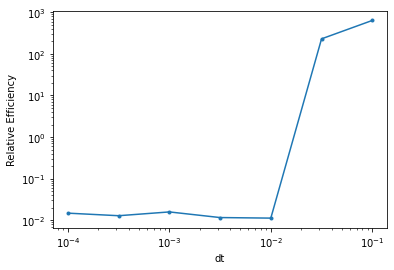

In [16]:
sol_0 = array(sol_0)
print(sol_0.shape)
effs = []
for i in range(len(sol_0)):
    vs = mean(sol_0[i][:,0],axis=0)
    burns = mean(sol_0[i][:,1],axis=0)
    effs.append(N/atot *vs**2 / burns)
plot(dts,effs,".-")
#legend()
xscale("log")
yscale('log')
xlabel("dt")
ylabel("Relative Efficiency")
    